In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from xgboost import XGBClassifier, plot_importance as xg_importance
from lightgbm import LGBMClassifier, plot_importance as lgb_importance

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [68]:
data = pd.read_csv('./creditcard.csv')

In [69]:
'''saciling '''

from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)

In [70]:
scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [71]:
def metrics(y_test, predict):
    acc = accuracy_score(y_test, predict)
    precision = precision_score(y_test, predict)
    recall = recall_score(y_test, predict)
    f1 = f1_score(y_test, predict)
    roc_score = roc_auc_score(y_test, predict)
    
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(acc, precision, recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1, roc_score))

def get_X_y_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0, stratify = y)
    return X_train, X_test, y_train, y_test

def modeling(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    metrics(y_test, pred)

In [72]:
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

X = data.drop('Class', axis=1)
y = data['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
#     print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    unique, counts = np.unique(original_ytrain, return_counts=True)
    print(unique, counts)
    unique, counts = np.unique(original_ytest, return_counts=True)
    print(unique, counts)
    
    lr = LogisticRegression()
    modeling(lr, original_Xtrain, original_Xtest, original_ytrain, original_ytest)

    lgb = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
    modeling(lgb,  original_Xtrain, original_Xtest, original_ytrain, original_ytest)
    
    print('*' * 20)

# # Turn into an array
# original_Xtrain = original_Xtrain.values
# original_Xtest = original_Xtest.values
# original_ytrain = original_ytrain.values
# original_ytest = original_ytest.values

# # See if both the train and test label distribution are similarly distributed
# train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
# test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
# print('-' * 100)

# print('Label Distributions: \n')
# print(train_counts_label)
# print(test_counts_label)
# print(train_counts_label/ len(original_ytrain))
# print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
[0 1] [227452    393]
[0 1] [56863    99]
정확도 : 1.00, 정밀도 : 0.70, 재현율 : 0.77
f1-score : 0.73, auc : 0.88
정확도 : 1.00, 정밀도 : 0.66, 재현율 : 0.90
f1-score : 0.76, auc : 0.95
********************
[0 1] [227452    393]
[0 1] [56863    99]
정확도 : 1.00, 정밀도 : 0.97, 재현율 : 0.64
f1-score : 0.77, auc : 0.82
정확도 : 1.00, 정밀도 : 0.98, 재현율 : 0.84
f1-score : 0.90, auc : 0.92
********************
[0 1] [227452    394]
[0 1] [56863    98]
정확도 : 1.00, 정밀도 : 0.91, 재현율 : 0.43
f1-score : 0.58, auc : 0.71
정확도 : 1.00, 정밀도 : 0.71, 재현율 : 0.68
f1-score : 0.69, auc : 0.84
********************
[0 1] [227452    394]
[0 1] [56863    98]
정확도 : 1.00, 정밀도 : 0.91, 재현율 : 0.68
f1-score : 0.78, auc : 0.84
정확도 : 1.00, 정밀도 : 0.98, 재현율 : 0.81
f1-score : 0.88, auc : 0.90
********************
[0 1] [227452    394]
[0 1] [56863    98]
정확도 : 1.00, 정밀도 : 0.94, 재현율 : 0.48
f1-score : 0.64, auc : 0.74
정확도 : 1.00, 정밀도 : 0.97, 재현율 : 0.68
f1-score : 0.80, auc : 0.84
**************

In [73]:
data = data.sample(frac=1)

fraud_df = data.loc[data['Class'] == 1]
print(fraud_df.shape[0])
non_fraud_df = data.loc[data['Class'] == 0][:fraud_df.shape[0]]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=20)
new_df.head()

492


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
96505,1.053588,-0.221948,1.005381,-0.169927,0.243381,1.152061,-0.641879,-0.789453,0.062229,0.028181,...,-0.120999,0.118278,0.009040,-0.136199,0.479732,0.505879,-0.359473,-0.024834,0.022720,0
110433,2.487249,-0.151188,-1.873281,-1.405339,1.326365,-1.800310,-0.920072,0.082732,0.251630,0.075790,...,-0.942559,0.020055,1.159000,0.373692,0.326702,-0.477861,-0.095532,0.154427,0.159538,0
17407,1.089779,-0.657902,-29.200329,16.155701,-30.013712,6.476731,-21.225810,-4.902997,-19.791248,19.168327,...,1.715862,1.809371,-2.175815,-1.365104,0.174286,2.103868,-0.209944,1.278681,0.372393,1
192529,-0.293440,0.529247,-1.396204,2.618584,-6.036770,3.552454,1.030091,-2.950358,-1.528506,0.189319,...,0.031795,0.143177,-0.390176,0.356029,-0.762352,0.096510,-0.487861,0.062655,-0.240732,1
50537,-0.293440,-0.471810,-0.234922,0.355413,1.972183,-1.255593,-0.681387,-0.665732,0.059110,-0.003153,...,-0.003469,0.220670,0.912107,-0.286338,0.451208,0.188315,-0.531846,0.123185,0.039581,1


Class
0    0.5
1    0.5
Name: count, dtype: float64


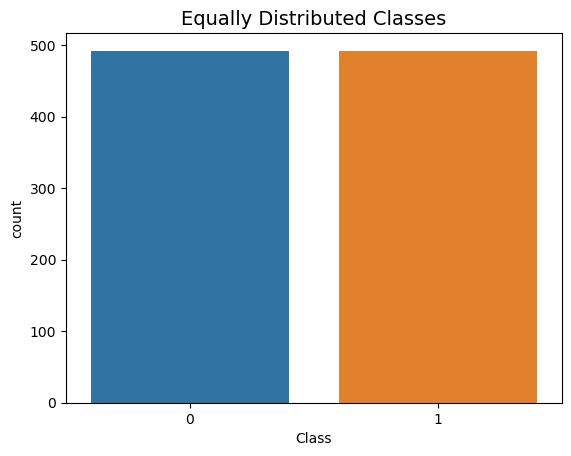

In [74]:
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(x = 'Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [75]:
new_df_copy = new_df.copy()

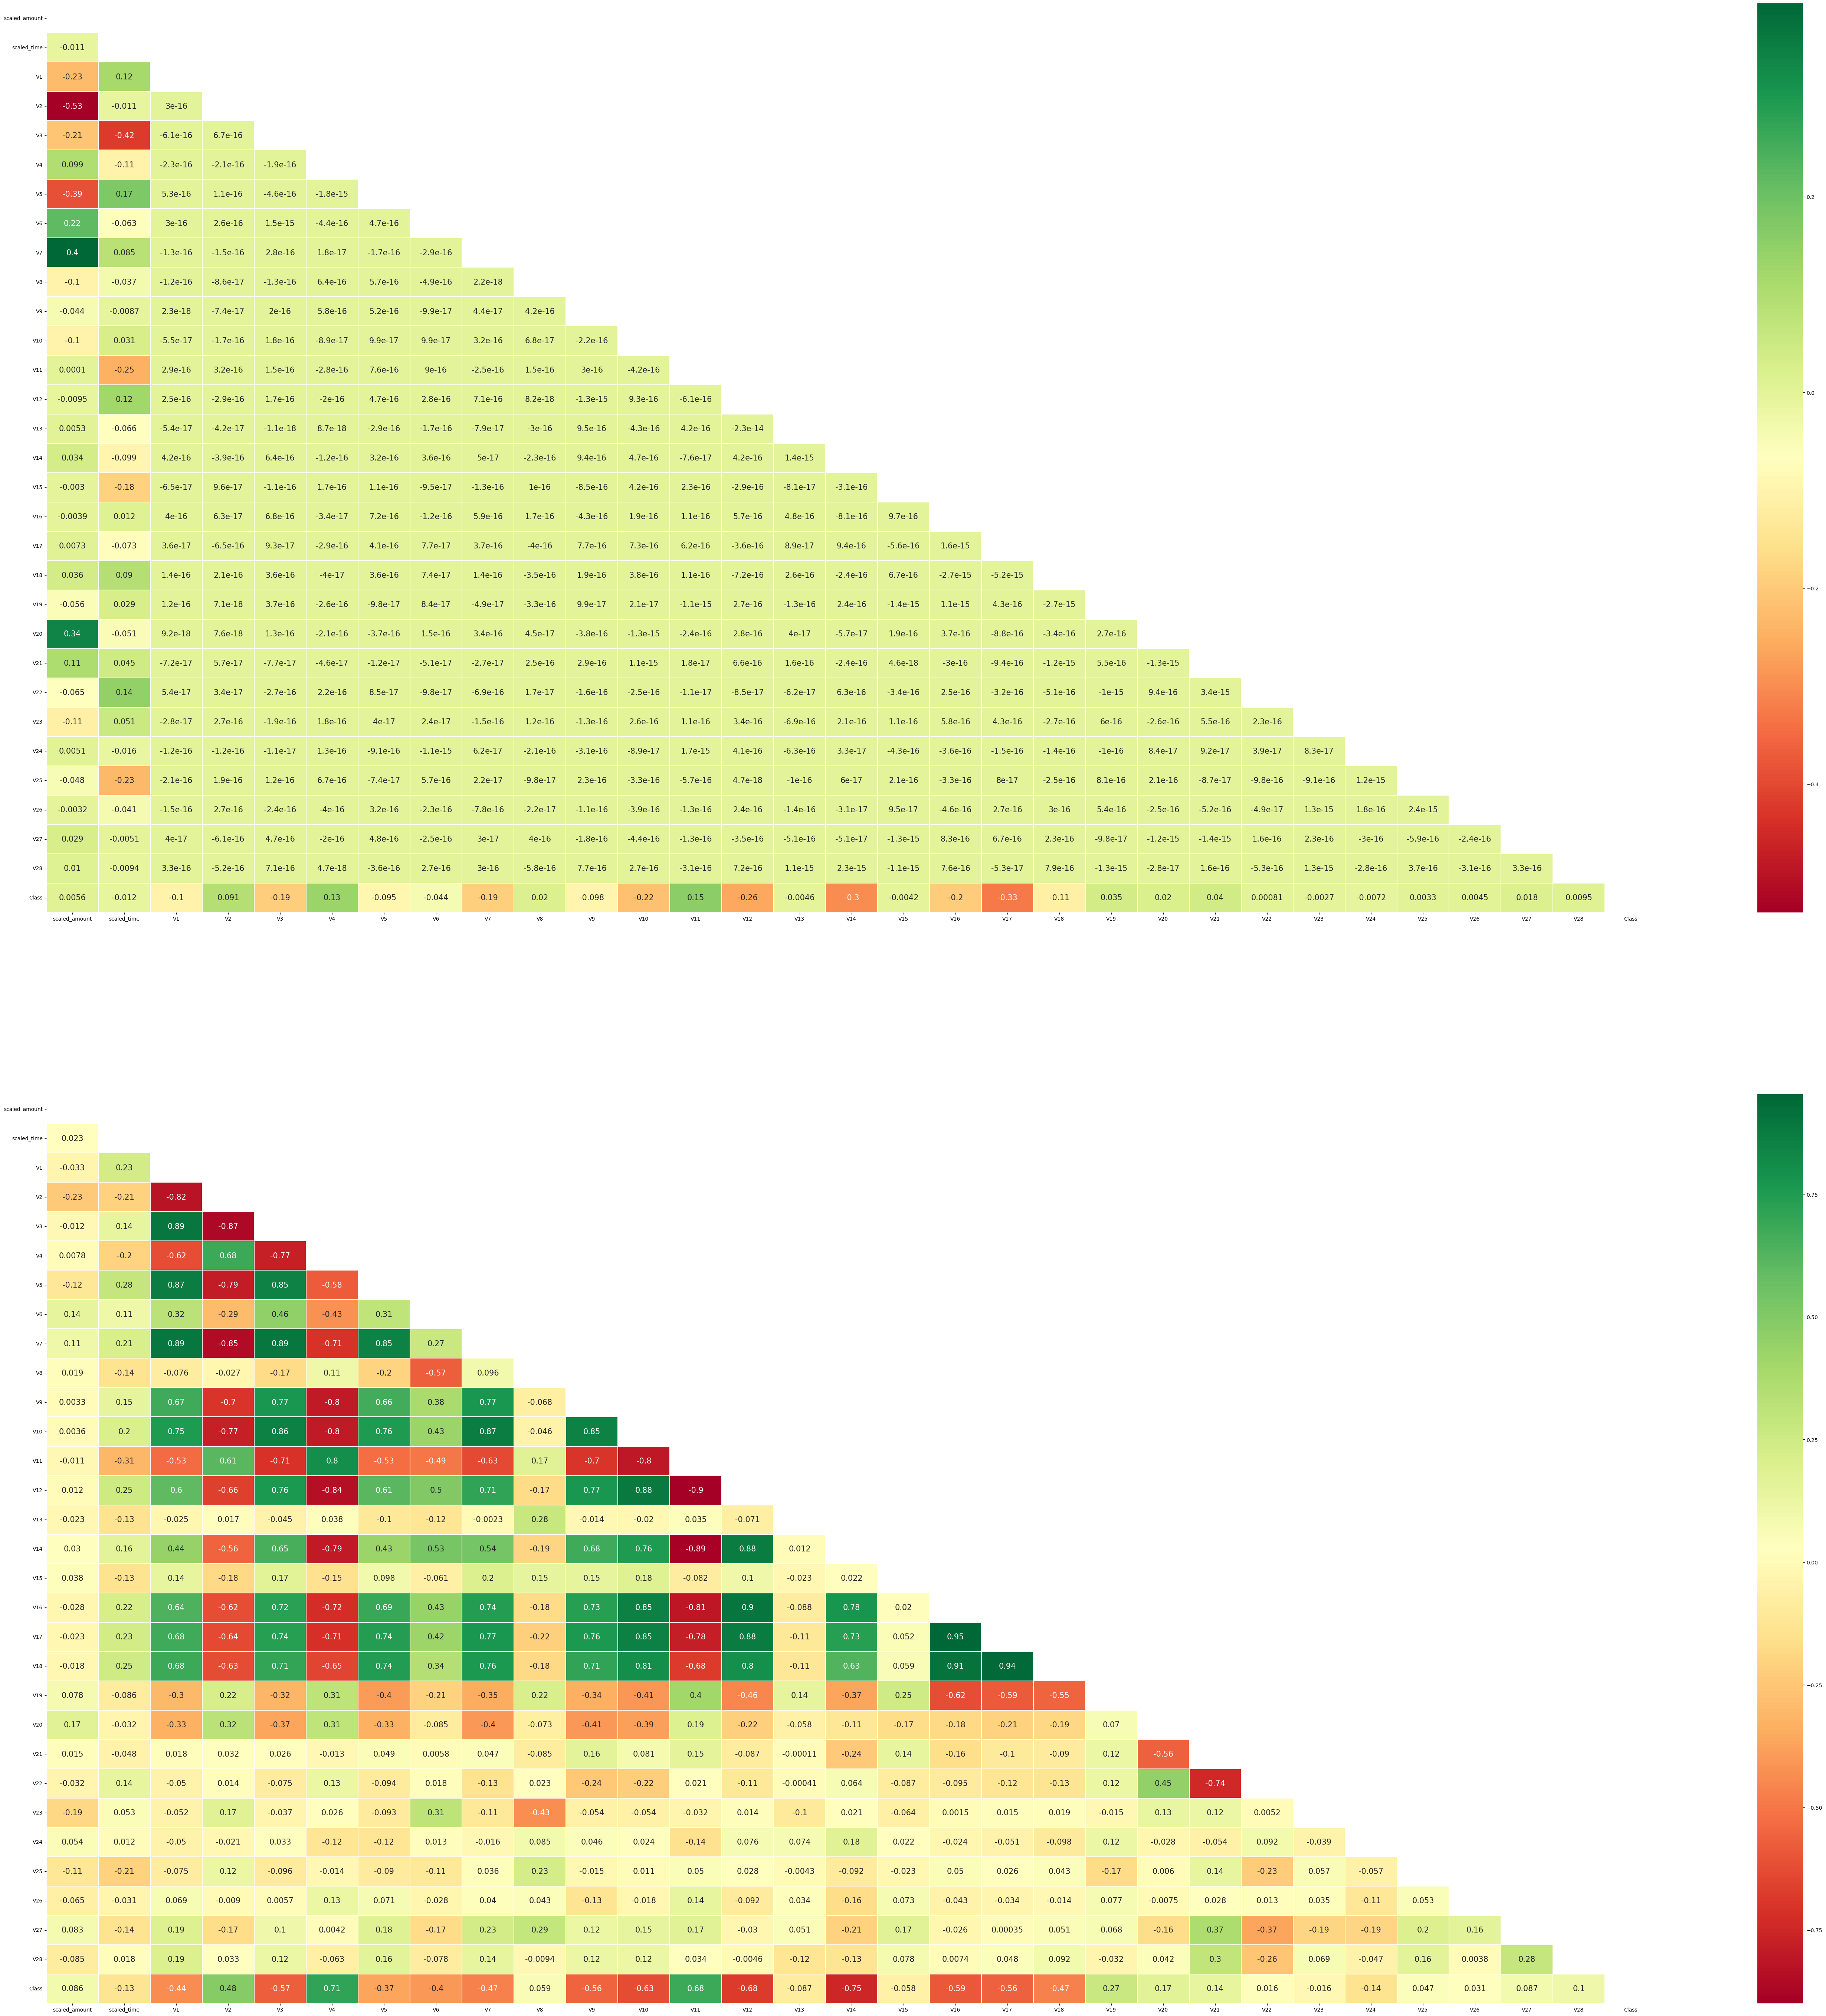

In [76]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(70,70))

mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(data.corr(), mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':15}, ax=ax1)

mask = np.zeros_like(new_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(new_df.corr(), mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':15}, ax=ax2)

plt.show()

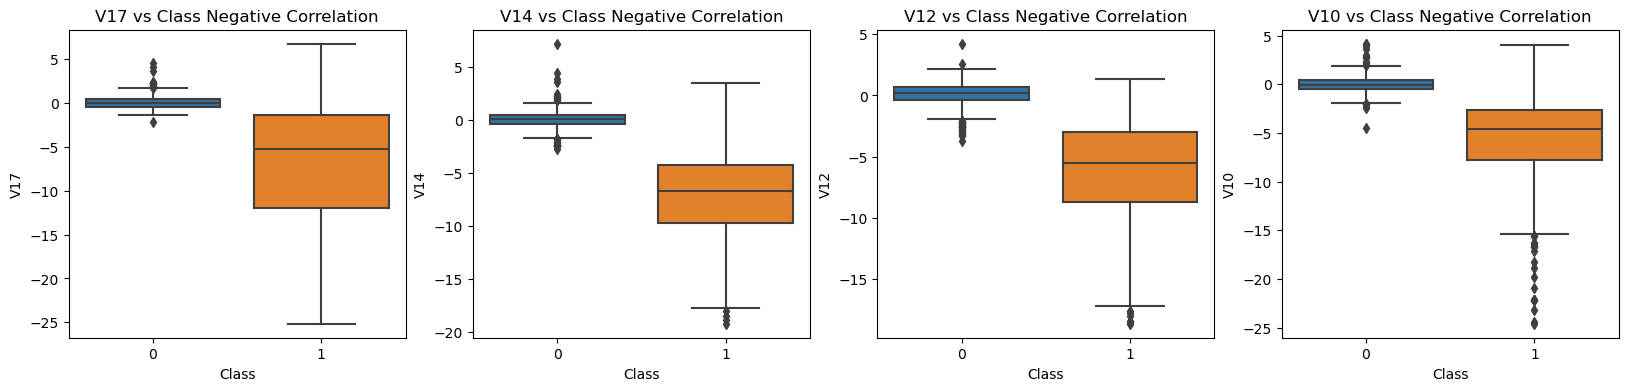

In [77]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=new_df,  ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df,ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df,  ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

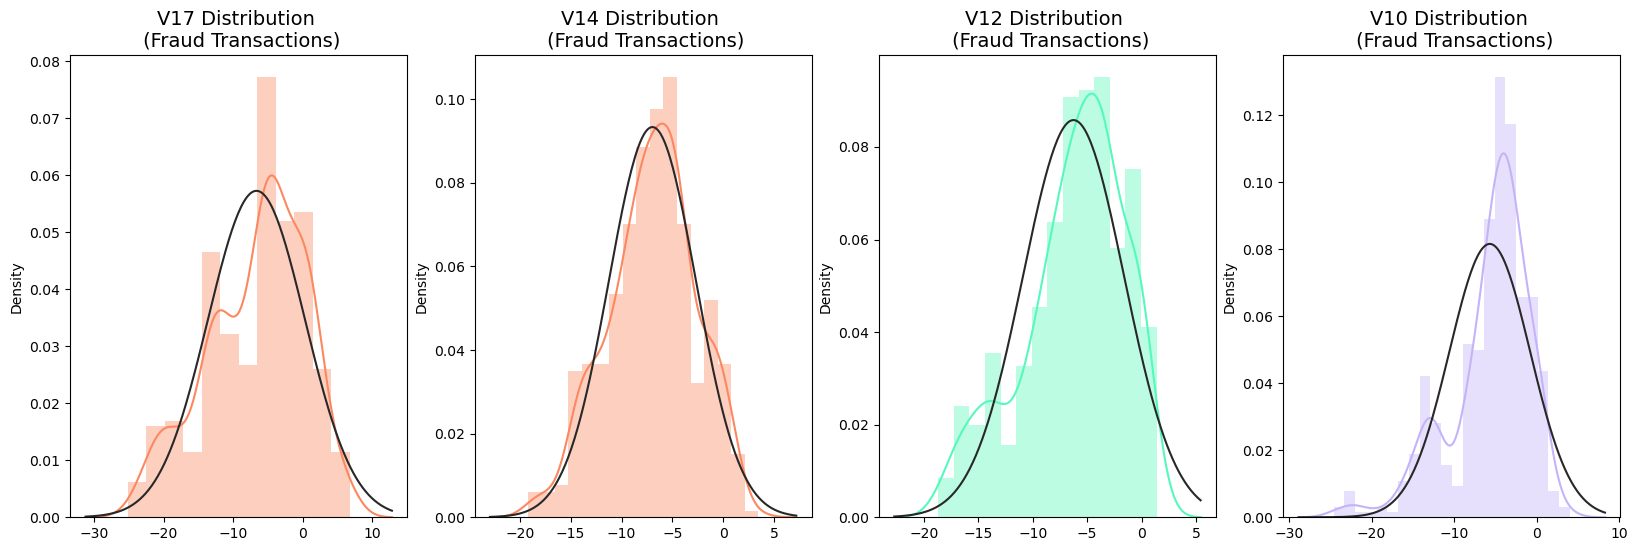

In [78]:
from scipy.stats import norm

f, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(20, 6))

v17_fraud_dist = new_df['V17'].loc[new_df['Class'] == 1].values
sns.distplot(v17_fraud_dist,ax=ax0, fit=norm, color='#FB8861')
ax0.set_title('V17 Distribution \n (Fraud Transactions)', fontsize=14)

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [79]:
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.8220867423816, -18.0499976898594, -18.4937733551053, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.5536970096458, -18.4311310279993, -18.6837146333443, -18.0475965708216]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 973
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-15.2399619587112, -17.141513

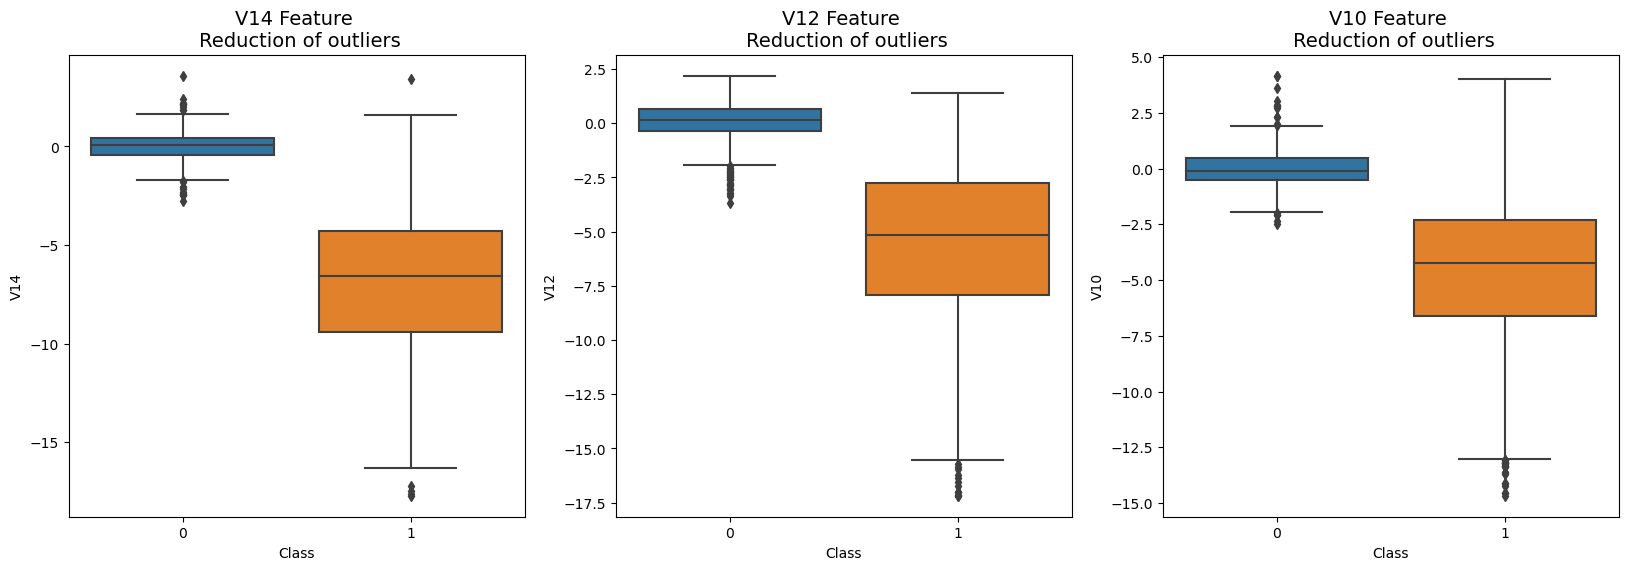

In [80]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)

plt.show()

In [81]:
print('outlier removced :', new_df.shape)
print('origin new df :' ,new_df_copy.shape)

outlier removced : (946, 31)
origin new df : (984, 31)


In [82]:
X_train, X_test, y_train, y_test = get_X_y_data(new_df)

lr = LogisticRegression()
modeling(lr, X_train, X_test, y_train, y_test)

lgb = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
modeling(lgb,  X_train, X_test, y_train, y_test)

정확도 : 0.95, 정밀도 : 0.95, 재현율 : 0.95
f1-score : 0.95, auc : 0.95
정확도 : 0.96, 정밀도 : 0.96, 재현율 : 0.96
f1-score : 0.96, auc : 0.96


In [83]:
'''outlier 제거 안한게 성능이 더 좋은데..?'''
X_train, X_test, y_train, y_test = get_X_y_data(new_df_copy)

lr = LogisticRegression()
modeling(lr, X_train, X_test, y_train, y_test)

lgb = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
modeling(lgb,  X_train, X_test, y_train, y_test)

정확도 : 0.96, 정밀도 : 0.97, 재현율 : 0.93
f1-score : 0.95, auc : 0.96
정확도 : 0.94, 정밀도 : 0.97, 재현율 : 0.91
f1-score : 0.94, auc : 0.94


# Dimensionality Reduction and Clustering


In [87]:
# New_df is from the random undersample data (fewer instances)
'''Time과 Amount에 대해서 scailing(normalize)하지 않은 데이터로 하면 효과가 없었음'''
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=20).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=20).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=20).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.3 s
PCA took 0.0088 s
Truncated SVD took 0.0055 s


In [88]:
new_df.shape

(946, 31)

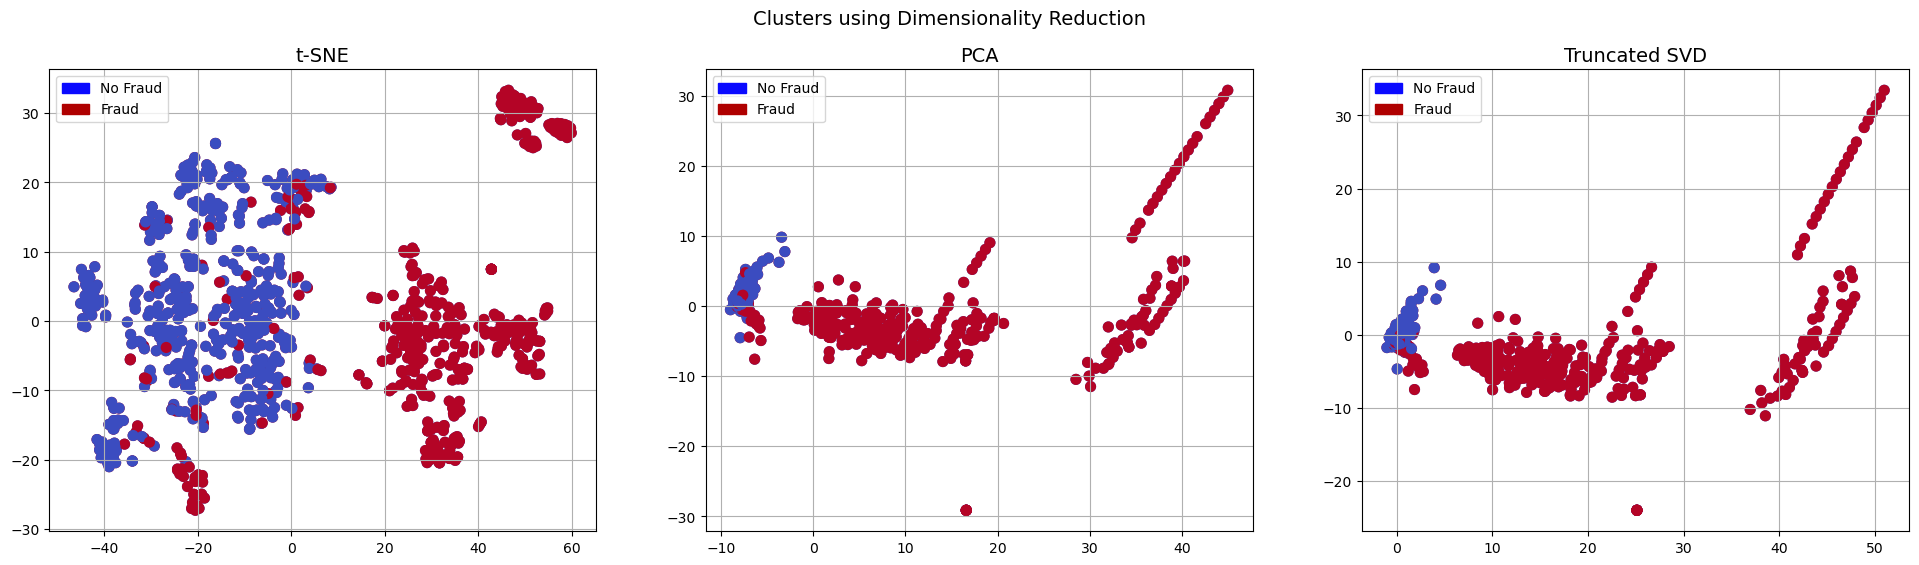

In [89]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()